In [1]:
import sys
import os
sys.path.append('../dags')

from database import create_database_engine


# 환경 변수 설정
os.environ["POSTGRES_USER"] = "airflow"
os.environ["POSTGRES_PASSWORD"] = "airflow"
os.environ["POSTGRES_DB"] = "events"
os.environ["POSTGRES_PORT"] = "5433"

engine = create_database_engine(host="127.0.0.1")
print("Successfully connected to the database")

Successfully connected to the database


In [2]:
import pandas as pd
from datetime import datetime
table = "disclosure_events"
# 날짜 범위 설정
start_date = datetime(2022, 7, 1)
end_date = datetime(2023, 12, 28)

query = f"""SELECT * FROM {table}
WHERE stock_code is not NULL
  AND market IN ('KOSPI', 'KOSDAQ', 'KOSDAQ GLOBAL')
  AND disclosed_at >= %(start_date)s
  AND disclosed_at <= %(end_date)s
ORDER BY id ASC"""

df = pd.read_sql(query, engine, params={"start_date": start_date, "end_date": end_date})
print(f"데이터베이스에서 조회된 공시 이벤트 수: {len(df)}")
df


DETAIL:  The database was created using collation version 2.36, but the operating system provides version 2.41.
HINT:  Rebuild all objects in this database that use the default collation and run ALTER DATABASE events REFRESH COLLATION VERSION, or build PostgreSQL with the right library version.


데이터베이스에서 조회된 공시 이벤트 수: 25939


,id,stock_code,market,company_name,report_name,disclosed_at,summary_kr,raw,created_at,ret_1m,ret_3m,ret_10m,ret_15m,ret_30m,ret_60m,label,score
0,32519,KR7114190002,KOSDAQ,강원에너지,타법인주식및출자증권취득결정(자율공시),2022-07-01 01:03:17+00:00,"강원에너지(시가총액 1,842억 원)는 2022년 7월 1일 강원이솔루션의 주식을 ...","2022.07.01 10:03:16\n기업명: 강원에너지(시가총액: 1,842억)\...",2025-08-09 19:13:15.234304,-0.14,0.00,-1.99,-3.55,-3.83,-3.69,neutral,0.9723
1,32520,KR7082920000,KOSDAQ,비츠로셀,단일판매ㆍ공급계약체결,2022-07-01 01:24:45+00:00,비츠로셀이 2022년 6월 30일부터 2023년 10월 20일까지 방위사업청과 리튬...,"2022.07.01 10:24:44\n기업명: 비츠로셀(시가총액: 2,477억)\n...",2025-08-09 19:13:15.234304,-0.85,0.43,0.00,1.28,0.85,0.85,positive,0.9959
2,32521,KR7042370007,KOSDAQ,비츠로테크,단일판매ㆍ공급계약체결(자회사의 주요경영사항),2022-07-01 01:27:02+00:00,비츠로테크는 방위사업청과 리튬전지류 및 기뢰정비장비용 전지조립체 공급 계약을 체결했...,"2022.07.01 10:27:02\n기업명: 비츠로테크(시가총액: 1,821억)\...",2025-08-09 19:13:15.234304,0.00,-0.14,-0.29,0.14,0.72,1.01,positive,0.9999
3,32522,KR7014820005,KOSPI,동원시스템즈,신규시설투자등(자율공시),2022-07-01 01:43:15+00:00,동원시스템즈는 2022년 7월 1일부터 2023년 7월 31일까지 585억 원을 신...,"2022.07.01 10:43:14\n기업명: 동원시스템즈(시가총액: 1조 5,61...",2025-08-09 19:13:15.234304,0.00,0.18,0.37,0.55,0.74,0.00,neutral,0.6471
4,32524,KR7226950004,KOSDAQ,올릭스,투자판단관련주요경영사항(노인성 황반변성 환자에서 OLX10212의 안전성 및 내약성...,2022-07-01 02:30:09+00:00,올릭스는 노인성 황반변성 치료를 위한 OLX10212의 제1상 임상시험을 미국에서 ...,"2022.07.01 11:30:08\n기업명: 올릭스(시가총액: 2,946억)\n보...",2025-08-09 19:13:15.234304,-1.60,-1.37,-0.68,-1.37,-2.28,-2.51,positive,0.9998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25934,68109,KR7383930005,KOSDAQ,디티앤씨알오,[투자주의]투자경고종목 지정예고,2023-12-27 09:50:43+00:00,"2023년 12월 27일, 디티앤씨알오가 투자경고종목 지정예고 대상에 올랐으며, 이...",보고서명 : [투자주의]투자경고종목 지정예고\n회사명 : 디티앤씨알오(시가총액 : ...,2025-07-08 17:09:03.053194,NaN,NaN,NaN,NaN,NaN,NaN,negative,0.9995
25935,68111,KR7059100008,KOSDAQ,아이컴포넌트,(예고)단기과열종목(3거래일 단일가매매) 지정예고,2023-12-27 09:50:47+00:00,아이컴포넌트는 2023년 12월 27일 단기 과열 종목(3거래일 단일가매매) 지정예...,보고서명 : (예고)단기과열종목(3거래일 단일가매매) 지정예고\n회사명 : 아이컴포...,2025-07-08 17:09:03.053194,NaN,NaN,NaN,NaN,NaN,NaN,neutral,0.9898
25936,68112,KR7298060005,KOSDAQ,에스씨엠생명과학,(예고)단기과열종목(3거래일 단일가매매) 지정예고,2023-12-27 09:50:49+00:00,"에스씨엠생명과학은 2023년 12월 27일, 단기 과열 종목으로 지정 예고되었으며,...",보고서명 : (예고)단기과열종목(3거래일 단일가매매) 지정예고\n회사명 : 에스씨엠...,2025-07-08 17:09:03.053194,NaN,NaN,NaN,NaN,NaN,NaN,negative,0.9893
25937,68113,KR7206650004,KOSDAQ,유바이오로직스,투자판단관련주요경영사항(임상시험계획승인신청)(대상포진 예방 백신 EuHZV(유에이치...,2023-12-27 22:48:21+00:00,유바이오로직스는 대상포진 예방 백신 EuHZV의 국내 제1상 임상시험계획 승인 신청...,"2023.12.28 07:48:20\n기업명: 유바이오로직스(시가총액: 4,156억...",2025-07-08 17:09:03.053194,NaN,NaN,NaN,NaN,NaN,NaN,positive,0.9998


시장별 공시 분포:
market
KOSDAQ           12969
KOSPI            11955
KOSDAQ GLOBAL     1015
Name: count, dtype: int64

총 공시 건수: 25939

시장별 비율:
KOSDAQ: 12969건 (50.0%)
KOSPI: 11955건 (46.1%)
KOSDAQ GLOBAL: 1015건 (3.9%)


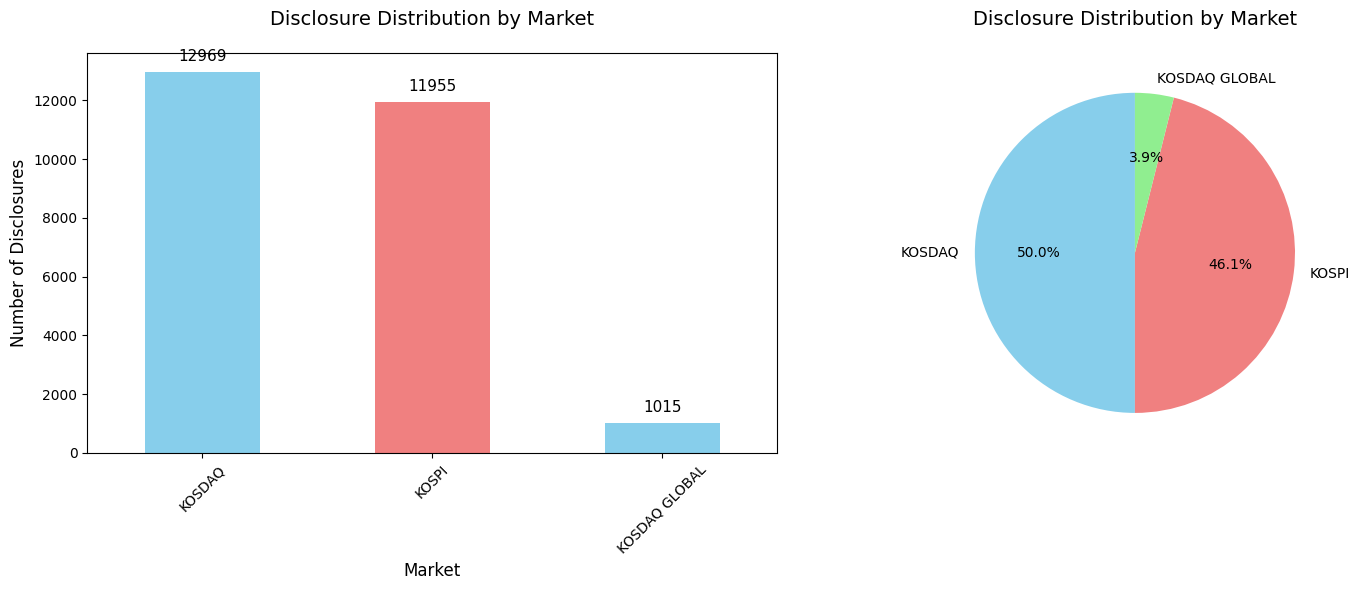

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# market 종류와 각각의 비율 분석
market_counts = df['market'].value_counts()
print("시장별 공시 분포:")
print(market_counts)
print(f"\n총 공시 건수: {len(df)}")
print("\n시장별 비율:")
for market, count in market_counts.items():
    ratio = count / len(df) * 100
    print(f"{market}: {count}건 ({ratio:.1f}%)")

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 막대 그래프
market_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral'])
ax1.set_title('Disclosure Distribution by Market', fontsize=14, pad=20)
ax1.set_xlabel('Market', fontsize=12)
ax1.set_ylabel('Number of Disclosures', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# 각 막대 위에 값 표시
for i, v in enumerate(market_counts.values):
    ax1.text(i, v + len(df)*0.01, str(v), ha='center', va='bottom', fontsize=11)

# 파이 차트
market_ratios = market_counts / len(df) * 100
ax2.pie(market_ratios.values, labels=market_ratios.index, autopct='%1.1f%%', 
        startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen'])
ax2.set_title('Disclosure Distribution by Market', fontsize=14, pad=20)

plt.tight_layout()
plt.show()


공시 발표 시간대별 분포:
market_session
After Hours      16318
Trading Hours     9621
Name: count, dtype: int64

장중 비율: 37.1%
장외 비율: 62.9%


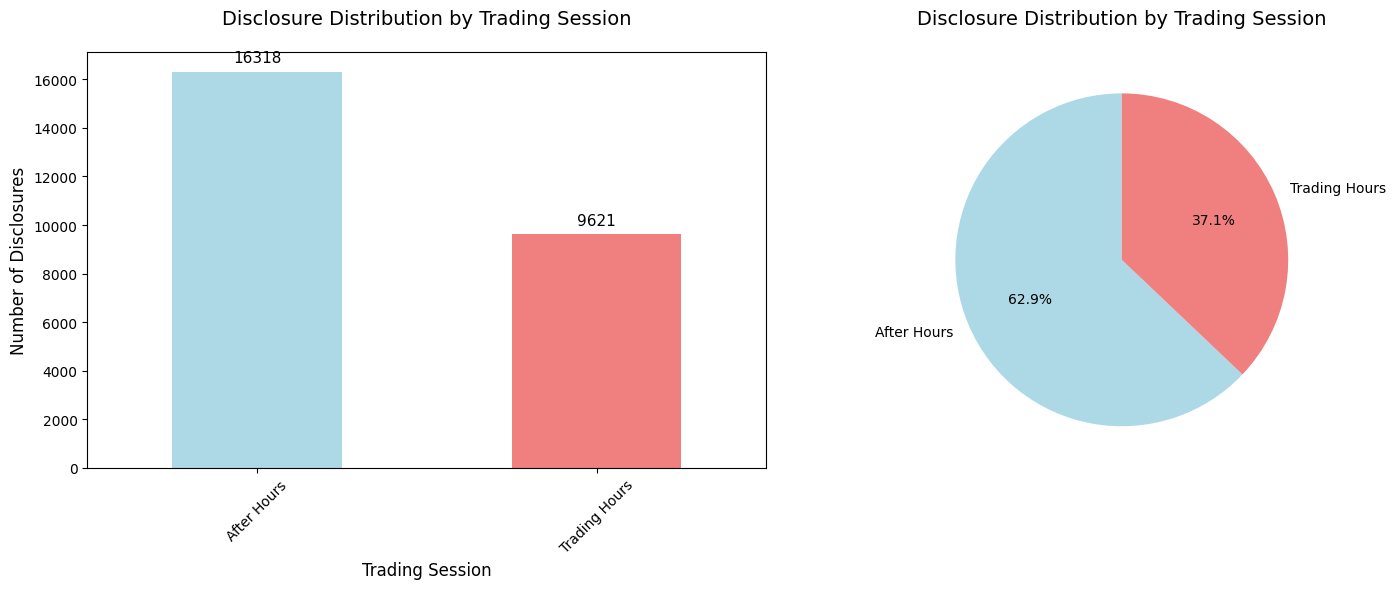

In [4]:
# disclosed_at을 datetime으로 변환 (이미 timezone-aware 상태)
df['disclosed_at'] = pd.to_datetime(df['disclosed_at'])

# 이미 timezone-aware이므로 tz_convert만 사용하여 KST로 변환
df['disclosed_at_kst'] = df['disclosed_at'].dt.tz_convert('Asia/Seoul')

# KST 시간에 따라 데이터프레임 정렬
df = df.sort_values('disclosed_at_kst')

# 시간만 추출 (KST 기준)
df['time_only'] = df['disclosed_at_kst'].dt.time

# 장중 시간 정의 (9:00 ~ 15:30)
import datetime
market_open = datetime.time(9, 0)
market_close = datetime.time(15, 30)

# 장중/장외 분류
df['market_session'] = df['time_only'].apply(
    lambda x: 'Trading Hours' if market_open <= x <= market_close else 'After Hours'
)

# 결과 집계
session_counts = df['market_session'].value_counts()
print("공시 발표 시간대별 분포:")
print(session_counts)
print(f"\n장중 비율: {session_counts.get('Trading Hours', 0) / len(df) * 100:.1f}%")
print(f"장외 비율: {session_counts.get('After Hours', 0) / len(df) * 100:.1f}%")

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 막대 그래프
session_counts.plot(kind='bar', ax=ax1, color=['lightblue', 'lightcoral'])
ax1.set_title('Disclosure Distribution by Trading Session', fontsize=14, pad=20)
ax1.set_xlabel('Trading Session', fontsize=12)
ax1.set_ylabel('Number of Disclosures', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# 각 막대 위에 값 표시
for i, v in enumerate(session_counts.values):
    ax1.text(i, v + len(df)*0.01, str(v), ha='center', va='bottom', fontsize=11)

# 파이 차트
session_ratios = session_counts / len(df) * 100
ax2.pie(session_ratios.values, labels=session_ratios.index, autopct='%1.1f%%', 
        startangle=90, colors=['lightblue', 'lightcoral'])
ax2.set_title('Disclosure Distribution by Trading Session', fontsize=14, pad=20)

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
from datetime import datetime

# 날짜 범위 설정
start_date = datetime(2022, 7, 1)
end_date = datetime(2023, 12, 28)

table = "disclosure_events"
query = f"""SELECT * FROM {table}
WHERE stock_code is not NULL
  AND summary_kr is not NULL
  AND market IN ('KOSPI', 'KOSDAQ', 'KOSDAQ GLOBAL') 
  AND (
      (EXTRACT(HOUR FROM disclosed_at AT TIME ZONE 'Asia/Seoul') BETWEEN 9 AND 14)
      OR
      (EXTRACT(HOUR FROM disclosed_at AT TIME ZONE 'Asia/Seoul') = 15
       AND EXTRACT(MINUTE FROM disclosed_at AT TIME ZONE 'Asia/Seoul') <= 30)
  )
  AND disclosed_at >= %(start_date)s
  AND disclosed_at <= %(end_date)s
ORDER BY id ASC"""

target_df = pd.read_sql(query, engine, params={"start_date": start_date, "end_date": end_date})

target_df

,id,stock_code,market,company_name,report_name,disclosed_at,summary_kr,raw,created_at,ret_1m,ret_3m,ret_10m,ret_15m,ret_30m,ret_60m,label,score
0,32519,KR7114190002,KOSDAQ,강원에너지,타법인주식및출자증권취득결정(자율공시),2022-07-01 01:03:17+00:00,"강원에너지(시가총액 1,842억 원)는 2022년 7월 1일 강원이솔루션의 주식을 ...","2022.07.01 10:03:16\n기업명: 강원에너지(시가총액: 1,842억)\...",2025-08-09 19:13:15.234304,-0.14,0.00,-1.99,-3.55,-3.83,-3.69,neutral,0.9723
1,32520,KR7082920000,KOSDAQ,비츠로셀,단일판매ㆍ공급계약체결,2022-07-01 01:24:45+00:00,비츠로셀이 2022년 6월 30일부터 2023년 10월 20일까지 방위사업청과 리튬...,"2022.07.01 10:24:44\n기업명: 비츠로셀(시가총액: 2,477억)\n...",2025-08-09 19:13:15.234304,-0.85,0.43,0.00,1.28,0.85,0.85,positive,0.9959
2,32521,KR7042370007,KOSDAQ,비츠로테크,단일판매ㆍ공급계약체결(자회사의 주요경영사항),2022-07-01 01:27:02+00:00,비츠로테크는 방위사업청과 리튬전지류 및 기뢰정비장비용 전지조립체 공급 계약을 체결했...,"2022.07.01 10:27:02\n기업명: 비츠로테크(시가총액: 1,821억)\...",2025-08-09 19:13:15.234304,0.00,-0.14,-0.29,0.14,0.72,1.01,positive,0.9999
3,32522,KR7014820005,KOSPI,동원시스템즈,신규시설투자등(자율공시),2022-07-01 01:43:15+00:00,동원시스템즈는 2022년 7월 1일부터 2023년 7월 31일까지 585억 원을 신...,"2022.07.01 10:43:14\n기업명: 동원시스템즈(시가총액: 1조 5,61...",2025-08-09 19:13:15.234304,0.00,0.18,0.37,0.55,0.74,0.00,neutral,0.6471
4,32524,KR7226950004,KOSDAQ,올릭스,투자판단관련주요경영사항(노인성 황반변성 환자에서 OLX10212의 안전성 및 내약성...,2022-07-01 02:30:09+00:00,올릭스는 노인성 황반변성 치료를 위한 OLX10212의 제1상 임상시험을 미국에서 ...,"2022.07.01 11:30:08\n기업명: 올릭스(시가총액: 2,946억)\n보...",2025-08-09 19:13:15.234304,-1.60,-1.37,-0.68,-1.37,-2.28,-2.51,positive,0.9998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9638,68075,KR7445090004,KOSDAQ,에이직랜드,주요사항보고서(회사합병결정),2023-12-27 05:31:32+00:00,에이직랜드는 반도체 디자인 서비스를 제공하는 자회사 탑에이직을 흡수합병하여 사업 통...,"2023.12.27 14:31:31\n기업명: 에이직랜드(시가총액: 6,396억)\...",2025-07-08 17:09:03.053194,0.33,0.17,-0.17,-0.67,-0.50,NaN,neutral,0.6333
9639,68076,KR7445090004,KOSDAQ,에이직랜드,주요사항보고서(회사합병결정),2023-12-27 05:33:57+00:00,에이직랜드는 반도체 디자인 서비스를 주력으로 하는 자회사 위즈마인드를 흡수합병하여 ...,"2023.12.27 14:33:56\n기업명: 에이직랜드(시가총액: 6,428억)\...",2025-07-08 17:09:03.053194,0.17,0.00,-0.17,-0.33,-0.50,NaN,positive,0.8485
9640,68077,KR7018310003,KOSDAQ,삼목에스폼,소송등의제기ㆍ신청(경영권분쟁소송),2023-12-27 05:48:48+00:00,삼목에스폼은 수원지방법원 평택지원에 장부 열람허용 가처분 신청 사건과 관련하여 영업...,"2023.12.27 14:48:47\n기업명: 삼목에스폼(시가총액: 2,436억)\...",2025-07-08 17:09:03.053194,-1.15,-0.12,-0.18,0.18,1.15,NaN,negative,0.9982
9641,68078,KR7012700001,KOSDAQ,리드코프,타법인주식및출자증권처분결정,2023-12-27 06:03:00+00:00,리드코프는 2024년 3월 31일까지 채권추심전문회사인 엘씨대부의 지분 11.71%...,"2023.12.27 15:02:59\n기업명: 리드코프(시가총액: 1,584억)\n...",2025-07-08 17:09:03.053194,0.00,-0.17,-0.17,0.00,NaN,NaN,neutral,0.9999


In [6]:
target_df.to_csv("target_df.csv", index=False)

In [7]:
print("\n=== 기본 데이터 분석 ===")

# 컬럼 정보
print(f"컬럼 수: {len(target_df.columns)}")
print(f"컬럼명: {list(target_df.columns)}")

# 데이터 타입
print("\n데이터 타입:")
print(target_df.dtypes)

# 결측값 확인
print("\n결측값 현황:")
print(target_df.isnull().sum())

# 수익률 컬럼 확인
ret_columns = ["ret_3m", "ret_10m", "ret_30m", "ret_60m"]
print(f"\n수익률 컬럼: {ret_columns}")


=== 기본 데이터 분석 ===
컬럼 수: 17
컬럼명: ['id', 'stock_code', 'market', 'company_name', 'report_name', 'disclosed_at', 'summary_kr', 'raw', 'created_at', 'ret_1m', 'ret_3m', 'ret_10m', 'ret_15m', 'ret_30m', 'ret_60m', 'label', 'score']

데이터 타입:
id                            int64
stock_code                   object
market                       object
company_name                 object
report_name                  object
disclosed_at    datetime64[ns, UTC]
summary_kr                   object
raw                          object
created_at           datetime64[ns]
ret_1m                      float64
ret_3m                      float64
ret_10m                     float64
ret_15m                     float64
ret_30m                     float64
ret_60m                     float64
label                        object
score                       float64
dtype: object

결측값 현황:
id                 0
stock_code         0
market             0
company_name       0
report_name        0
disclosed_at       0
su


=== 키워드 기반 공시 유형별 분석 ===
총 41개의 공시 카테고리가 있습니다.

공시 카테고리별 분포:
disclosure_category
실적공시        3722
지분공시        1390
IR활동        1197
공급계약체결      1170
매출변동         424
자사주취득        308
자산양수도        164
투자판단         127
유무상증자        119
전환가액조정       107
조회공시         105
자율공시         103
특허권           88
수시공시          85
자사주처분         74
신규투자          73
소송            60
임상시험계획신청      51
배당            30
전환사채권발행       29
임상시험계획승인      26
자사주소각         25
전환청구권행사       23
장래계획          22
회사합병          22
기술료수령         14
품목허가신청        13
자회사경영         13
회사분할          10
영업정지           9
품목허가승인         8
임상시험결과         7
국책과제           7
감자             4
임상시험계획철회       4
기술이전           3
영업양수도          2
임상관련           2
해외진출           1
주식교환이전         1
기타             1
Name: count, dtype: int64

수익률 데이터가 있는 공시 건수: 9088
전체 대비 비율: 94.2%

수익률 데이터가 있는 공시 카테고리별 건수:
disclosure_category
실적공시        3570
지분공시        1301
IR활동        1130
공급계약체결      1076
매출변동         372
자사주취득        291
자산양수도 

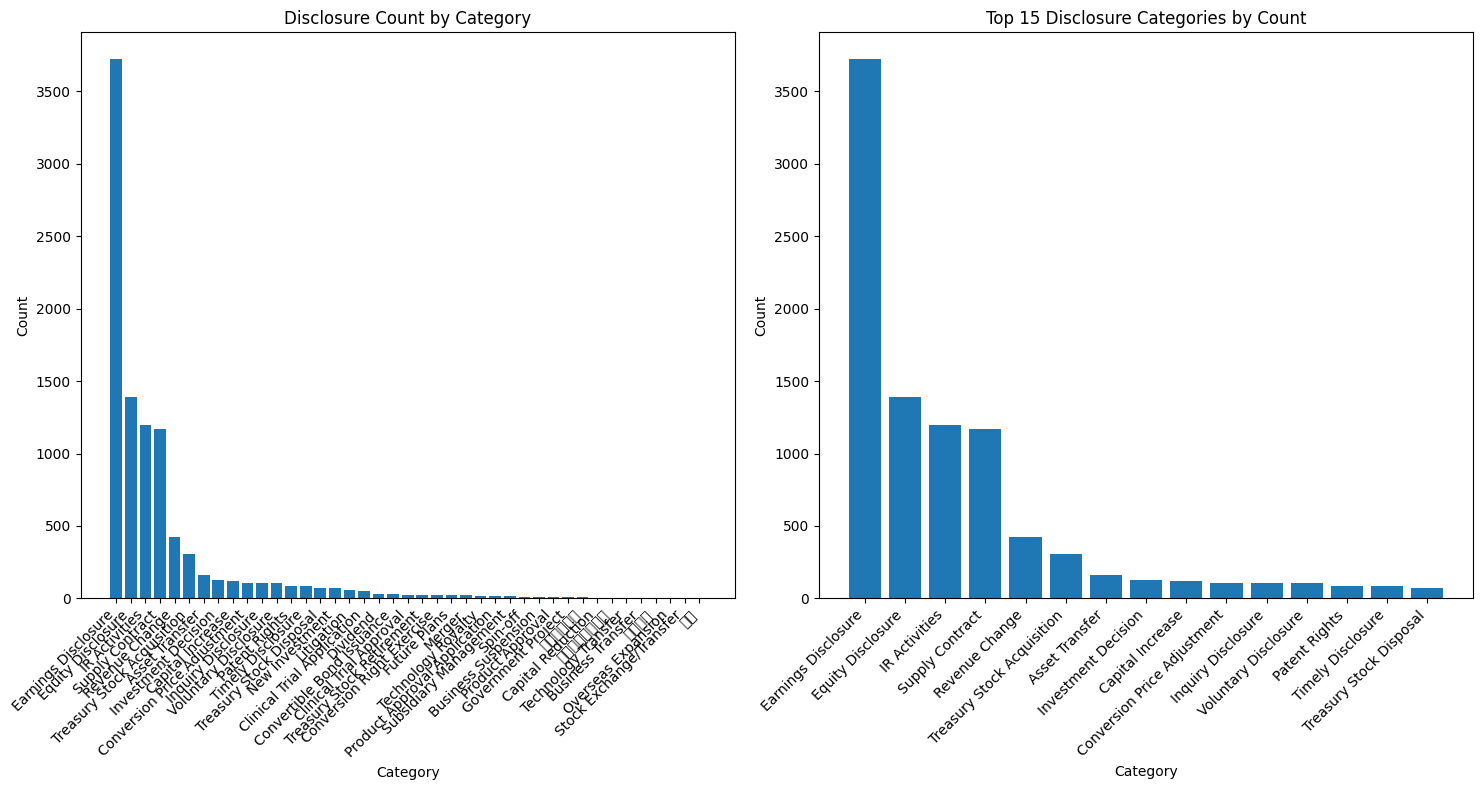

총 41개 카테고리, 총 9643건의 공시

상위 15개 카테고리:
disclosure_category
실적공시      3722
지분공시      1390
IR활동      1197
공급계약체결    1170
매출변동       424
자사주취득      308
자산양수도      164
투자판단       127
유무상증자      119
전환가액조정     107
조회공시       105
자율공시       103
특허권         88
수시공시        85
자사주처분       74
Name: count, dtype: int64


In [8]:
import sys
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

sys.path.append("../analysis")

from eda_helper import analyze_disclosure_types_by_keywords, calculate_return_statistics_by_category

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 한글-영어 카테고리 매핑
category_mapping = {
    "자산양수도": "Asset Transfer",
    "부도발생": "Default",
    "영업정지": "Business Suspension",
    "회생절차": "Rehabilitation",
    "해산": "Dissolution",
    "유무상증자": "Capital Increase",
    "감자": "Capital Reduction",
    "채권은행관리": "Creditor Bank Management",
    "소송": "Litigation",
    "해외상장": "Overseas Listing",
    "신주인수권부사채권": "Bond with Warrant",
    "교환사채권": "Exchangeable Bond",
    "상각형조건부자본증권": "Contingent Capital Securities",
    "자사주취득": "Treasury Stock Acquisition",
    "자사주처분": "Treasury Stock Disposal",
    "자사주소각": "Treasury Stock Retirement",
    "전환사채권발행": "Convertible Bond Issuance",
    "영업양수도": "Business Transfer",
    "회사합병": "Merger",
    "회사분할": "Spin-off",
    "주식교환이전": "Stock Exchange/Transfer",
    "공급계약체결": "Supply Contract",
    "IR활동": "IR Activities",
    "실적공시": "Earnings Disclosure",
    "특허권": "Patent Rights",
    "기술료수령": "Technology Royalty",
    "기술이전": "Technology Transfer",
    "품목허가승인": "Product Approval",
    "품목허가신청": "Product Approval Application",
    "임상시험계획신청": "Clinical Trial Application",
    "임상시험계획승인": "Clinical Trial Approval",
    "전환가액조정": "Conversion Price Adjustment",
    "지분공시": "Equity Disclosure",
    "신규투자": "New Investment",
    "조회공시": "Inquiry Disclosure",
    "수시공시": "Timely Disclosure",
    "장래계획": "Future Plans",
    "매출변동": "Revenue Change",
    "전환청구권행사": "Conversion Right Exercise",
    "자문용역": "Advisory Services",
    "국책과제": "Government Project",
    "해외진출": "Overseas Expansion",
    "자회사경영": "Subsidiary Management",
    "자율공시": "Voluntary Disclosure",
    "공정공시": "Fair Disclosure",
    "안내공시": "Information Disclosure",
    "배당": "Dividend",
    "투자판단": "Investment Decision"
}

df_with_returns, category_counts = analyze_disclosure_types_by_keywords(target_df, ret_columns = ret_columns)

# 카테고리별 건수 시각화
plt.figure(figsize=(15, 8))
category_counts_sorted = category_counts.sort_values(ascending=False)

# 한글 카테고리를 영어로 매핑
category_counts_sorted_en = category_counts_sorted.copy()
category_counts_sorted_en.index = [category_mapping.get(cat, cat) for cat in category_counts_sorted_en.index]

plt.subplot(1, 2, 1)
plt.bar(range(len(category_counts_sorted_en)), category_counts_sorted_en.values)
plt.title('Disclosure Count by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(range(len(category_counts_sorted_en)), category_counts_sorted_en.index, rotation=45, ha='right')

# 상위 15 카테고리만 별도 표시
plt.subplot(1, 2, 2)
top_10 = category_counts_sorted_en.head(15)
plt.bar(range(len(top_10)), top_10.values)
plt.title('Top 15 Disclosure Categories by Count')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(range(len(top_10)), top_10.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"총 {len(category_counts)}개 카테고리, 총 {category_counts.sum()}건의 공시")
print("\n상위 15개 카테고리:")
print(category_counts_sorted.head(15))

In [9]:
df_with_returns

,id,stock_code,market,company_name,report_name,disclosed_at,summary_kr,raw,created_at,ret_1m,ret_3m,ret_10m,ret_15m,ret_30m,ret_60m,label,score,disclosure_category
0,32519,KR7114190002,KOSDAQ,강원에너지,타법인주식및출자증권취득결정(자율공시),2022-07-01 01:03:17+00:00,"강원에너지(시가총액 1,842억 원)는 2022년 7월 1일 강원이솔루션의 주식을 ...","2022.07.01 10:03:16\n기업명: 강원에너지(시가총액: 1,842억)\...",2025-08-09 19:13:15.234304,-0.14,0.00,-1.99,-3.55,-3.83,-3.69,neutral,0.9723,자산양수도
1,32520,KR7082920000,KOSDAQ,비츠로셀,단일판매ㆍ공급계약체결,2022-07-01 01:24:45+00:00,비츠로셀이 2022년 6월 30일부터 2023년 10월 20일까지 방위사업청과 리튬...,"2022.07.01 10:24:44\n기업명: 비츠로셀(시가총액: 2,477억)\n...",2025-08-09 19:13:15.234304,-0.85,0.43,0.00,1.28,0.85,0.85,positive,0.9959,공급계약체결
2,32521,KR7042370007,KOSDAQ,비츠로테크,단일판매ㆍ공급계약체결(자회사의 주요경영사항),2022-07-01 01:27:02+00:00,비츠로테크는 방위사업청과 리튬전지류 및 기뢰정비장비용 전지조립체 공급 계약을 체결했...,"2022.07.01 10:27:02\n기업명: 비츠로테크(시가총액: 1,821억)\...",2025-08-09 19:13:15.234304,0.00,-0.14,-0.29,0.14,0.72,1.01,positive,0.9999,공급계약체결
3,32522,KR7014820005,KOSPI,동원시스템즈,신규시설투자등(자율공시),2022-07-01 01:43:15+00:00,동원시스템즈는 2022년 7월 1일부터 2023년 7월 31일까지 585억 원을 신...,"2022.07.01 10:43:14\n기업명: 동원시스템즈(시가총액: 1조 5,61...",2025-08-09 19:13:15.234304,0.00,0.18,0.37,0.55,0.74,0.00,neutral,0.6471,신규투자
4,32524,KR7226950004,KOSDAQ,올릭스,투자판단관련주요경영사항(노인성 황반변성 환자에서 OLX10212의 안전성 및 내약성...,2022-07-01 02:30:09+00:00,올릭스는 노인성 황반변성 치료를 위한 OLX10212의 제1상 임상시험을 미국에서 ...,"2022.07.01 11:30:08\n기업명: 올릭스(시가총액: 2,946억)\n보...",2025-08-09 19:13:15.234304,-1.60,-1.37,-0.68,-1.37,-2.28,-2.51,positive,0.9998,임상시험계획신청
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9638,68075,KR7445090004,KOSDAQ,에이직랜드,주요사항보고서(회사합병결정),2023-12-27 05:31:32+00:00,에이직랜드는 반도체 디자인 서비스를 제공하는 자회사 탑에이직을 흡수합병하여 사업 통...,"2023.12.27 14:31:31\n기업명: 에이직랜드(시가총액: 6,396억)\...",2025-07-08 17:09:03.053194,0.33,0.17,-0.17,-0.67,-0.50,NaN,neutral,0.6333,회사합병
9639,68076,KR7445090004,KOSDAQ,에이직랜드,주요사항보고서(회사합병결정),2023-12-27 05:33:57+00:00,에이직랜드는 반도체 디자인 서비스를 주력으로 하는 자회사 위즈마인드를 흡수합병하여 ...,"2023.12.27 14:33:56\n기업명: 에이직랜드(시가총액: 6,428억)\...",2025-07-08 17:09:03.053194,0.17,0.00,-0.17,-0.33,-0.50,NaN,positive,0.8485,회사합병
9640,68077,KR7018310003,KOSDAQ,삼목에스폼,소송등의제기ㆍ신청(경영권분쟁소송),2023-12-27 05:48:48+00:00,삼목에스폼은 수원지방법원 평택지원에 장부 열람허용 가처분 신청 사건과 관련하여 영업...,"2023.12.27 14:48:47\n기업명: 삼목에스폼(시가총액: 2,436억)\...",2025-07-08 17:09:03.053194,-1.15,-0.12,-0.18,0.18,1.15,NaN,negative,0.9982,소송
9641,68078,KR7012700001,KOSDAQ,리드코프,타법인주식및출자증권처분결정,2023-12-27 06:03:00+00:00,리드코프는 2024년 3월 31일까지 채권추심전문회사인 엘씨대부의 지분 11.71%...,"2023.12.27 15:02:59\n기업명: 리드코프(시가총액: 1,584억)\n...",2025-07-08 17:09:03.053194,0.00,-0.17,-0.17,0.00,NaN,NaN,neutral,0.9999,자산양수도


In [10]:
df_with_returns[df_with_returns["disclosure_category"] == "자사주소각"]

,id,stock_code,market,company_name,report_name,disclosed_at,summary_kr,raw,created_at,ret_1m,ret_3m,ret_10m,ret_15m,ret_30m,ret_60m,label,score,disclosure_category
2888,43686,KR7216080002,KOSDAQ,제테마,기타경영사항(자율공시)(제8회 무기명 무보증 사모 전환사채 소각결정),2022-12-14 02:05:17+00:00,"제테마는 2022년 12월 14일 만기전 일부 전환사채 132억 원을 소각했으며, ...","2022.12.14 11:05:16\n기업명: 제테마(시가총액: 2,592억)\n보...",2025-08-09 19:13:22.574979,0.68,-1.37,-1.02,-0.68,-0.34,-1.02,positive,0.5985,자사주소각
4575,51024,KR7107590002,KOSPI,미원홀딩스,주식소각결정(자회사의 주요경영사항),2023-03-22 04:25:11+00:00,"미원홀딩스는 자회사의 주식 소각을 결정했음을 공시하며, 관련 상세 내용은 금융감독원...","2023.03.22 13:25:10\n기업명: 미원홀딩스(시가총액: 2,304억)\...",2025-08-09 19:13:26.387872,-5.16,-5.82,-5.07,-4.69,-6.01,-5.92,neutral,0.6594,자사주소각
5395,54932,KR7025980004,KOSDAQ,아난티,"기타경영사항(자율공시)(자기사채 (제4회차, 제5회차 전환사채) 180억원 소각결정)",2023-05-15 01:47:38+00:00,아난티는 이사회의 결정을 통해 180억 원 규모의 제4회차와 제5회차 전환사채를 소...,"2023.05.15 10:47:37\n기업명: 아난티(시가총액: 5,645억)\n보...",2025-08-09 19:13:28.939299,0.00,0.15,0.62,0.62,0.62,1.08,neutral,0.9514,자사주소각
6641,58786,KR7107590002,KOSPI,미원홀딩스,주식소각결정(자회사의 주요경영사항),2023-07-13 05:44:32+00:00,"미원홀딩스는 자회사의 주요경영사항으로 주식 소각 결정을 공시하였으며, 시가총액은 2...","2023.07.13 14:44:31\n기업명: 미원홀딩스(시가총액: 2,276억)\...",2025-08-09 19:13:32.523956,0.00,1.12,0.92,0.92,0.92,NaN,neutral,0.9986,자사주소각
6817,59292,KR7347770000,KOSDAQ,핌스,주식소각결정,2023-07-26 00:46:24+00:00,"핀스는 주식소각 결정을 발표했으며, 시가총액은 1,474억 원입니다. 자세한 내용은...","20230726 09:46:20\n기업명: 핌스(시가총액: 1,474억)\n보고서명...",2025-08-09 19:13:32.523956,0.73,0.26,0.52,1.04,1.57,-1.57,neutral,0.9980,자사주소각
6895,59425,KR7055550008,KOSPI,신한지주,주식소각결정,2023-07-27 04:39:29+00:00,"신한지주는 2023년 7월 27일 주식소각 결정을 공시했으며, 이를 통해 주주가치 ...",20230727 13:39:27\n기업명: 신한지주(시가총액: 18조 644억)\n...,2025-08-09 19:13:32.523956,0.00,0.00,0.00,0.29,0.00,0.00,neutral,0.9998,자사주소각
6916,59453,KR7003480001,KOSPI,한진중공업홀딩스,주식소각결정(자회사의 주요경영사항),2023-07-27 05:40:51+00:00,"한진중공업홀딩스는 자회사 관련 주식 소각 결정을 발표했으며, 이는 기업의 주요 경영...","20230727 14:40:49\n기업명: 한진중공업홀딩스(시가총액: 1,019억)...",2025-08-09 19:13:32.523956,-0.58,0.00,-0.72,0.00,0.00,NaN,neutral,0.5647,자사주소각
7810,62764,KR7035150002,KOSPI,백산,주식소각결정,2023-08-29 04:30:11+00:00,"백산은 2023년 8월 29일 주식소각을 결정했으며, 소각 대상은 510,000주의...","2023.08.29 13:30:08\n기업명: 백산(시가총액: 1,820억)\n보고...",2025-08-09 19:13:33.784175,1.26,0.63,-0.13,0.51,0.25,0.76,neutral,0.8083,자사주소각
7943,63183,KR7005440003,KOSPI,현대지에프홀딩스,주식소각결정,2023-09-11 02:42:18+00:00,"현대지에프홀딩스는 2023년 12월 12일 자사주소각을 예정하고 있으며, 소각 비율...","2023.09.11 11:42:16\n기업명: 현대지에프홀딩스(시가총액: 2,489...",2025-08-09 19:13:34.823575,-0.12,-2.00,-5.62,-5.62,-3.25,-4.00,positive,0.9991,자사주소각
8283,64043,KR7011780004,KOSPI,금호석유화학,주식소각결정,2023-10-16 05:03:33+00:00,"금호석유화학은 2023년 10월 23일 기준으로 보통주 766,633주(전체 주식의...","2023.10.16 14:03:31\n기업명: 금호석유화학(시가총액: 3조 7,40...",2025-08-09 19:13:36.091146,0.08,0.16,0.55,0.08,0.93,0.31,positive,0.9796,자사주소각


In [11]:
import os

# analysis/type 폴더 생성 (없으면 만들기)
type_folder = "../analysis/type"
os.makedirs(type_folder, exist_ok=True)

# 각 카테고리별로 CSV 파일 저장
print("\n=== 카테고리별 CSV 파일 저장 ===")

for category in df_with_returns['disclosure_category'].unique():
    # 해당 카테고리의 데이터 필터링
    category_data = df_with_returns[df_with_returns['disclosure_category'] == category]
    
    # company_name, report_name 컬럼만 선택
    category_data_selected = category_data[['disclosed_at', 'company_name', 'report_name']]
    
    # 파일명 생성 (특수문자 제거)
    safe_filename = category.replace("/", "_").replace("\\", "_").replace(":", "_").replace("*", "_").replace("?", "_").replace("\"", "_").replace("<", "_").replace(">", "_").replace("|", "_")
    filename = f"{safe_filename}.csv"
    filepath = os.path.join(type_folder, filename)
    
    # CSV 파일로 저장
    category_data_selected.to_csv(filepath, index=False, encoding='utf-8-sig')
    
    print(f"{category}: {len(category_data)}건 -> {filename}")

print(f"\n총 {len(df_with_returns['disclosure_category'].unique())}개 카테고리의 CSV 파일이 {type_folder} 폴더에 저장되었습니다.")



=== 카테고리별 CSV 파일 저장 ===
자산양수도: 154건 -> 자산양수도.csv
공급계약체결: 1076건 -> 공급계약체결.csv
신규투자: 71건 -> 신규투자.csv
임상시험계획신청: 50건 -> 임상시험계획신청.csv
자사주처분: 71건 -> 자사주처분.csv
자사주취득: 291건 -> 자사주취득.csv
유무상증자: 114건 -> 유무상증자.csv
IR활동: 1130건 -> IR활동.csv
지분공시: 1301건 -> 지분공시.csv
자율공시: 93건 -> 자율공시.csv
전환가액조정: 93건 -> 전환가액조정.csv
자회사경영: 12건 -> 자회사경영.csv
투자판단: 123건 -> 투자판단.csv
장래계획: 22건 -> 장래계획.csv
실적공시: 3570건 -> 실적공시.csv
조회공시: 100건 -> 조회공시.csv
특허권: 85건 -> 특허권.csv
기술료수령: 12건 -> 기술료수령.csv
수시공시: 84건 -> 수시공시.csv
임상시험계획철회: 4건 -> 임상시험계획철회.csv
감자: 4건 -> 감자.csv
회사분할: 10건 -> 회사분할.csv
소송: 53건 -> 소송.csv
영업양수도: 2건 -> 영업양수도.csv
임상시험계획승인: 25건 -> 임상시험계획승인.csv
전환사채권발행: 27건 -> 전환사채권발행.csv
임상시험결과: 7건 -> 임상시험결과.csv
매출변동: 372건 -> 매출변동.csv
전환청구권행사: 18건 -> 전환청구권행사.csv
품목허가승인: 8건 -> 품목허가승인.csv
국책과제: 6건 -> 국책과제.csv
회사합병: 22건 -> 회사합병.csv
영업정지: 7건 -> 영업정지.csv
자사주소각: 24건 -> 자사주소각.csv
품목허가신청: 11건 -> 품목허가신청.csv
기술이전: 3건 -> 기술이전.csv
해외진출: 1건 -> 해외진출.csv
배당: 30건 -> 배당.csv
주식교환이전: 1건 -> 주식교환이전.csv
기타: 1건 -> 기타.csv

총 40개 카테고리의 CSV 파일이 ../analysis/t

In [12]:
calculate_return_statistics_by_category(df_with_returns, ret_columns)[["ret_3m_count", "ret_3m_mean", "ret_3m_std", "ret_3m_positive_ratio"]]


=== 공시 카테고리별 수익률 통계 ===


,ret_3m_count,ret_3m_mean,ret_3m_std,ret_3m_positive_ratio
disclosure_category,,,,
실적공시,3569,0.008,1.081,35.9
지분공시,1301,0.019,0.487,33.3
IR활동,1130,0.064,0.480,36.5
공급계약체결,1076,-0.139,2.099,39.0
매출변동,372,-0.165,1.038,34.1
자사주취득,291,0.068,1.749,42.3
자산양수도,154,-0.176,1.077,32.5
투자판단,123,-0.017,2.094,37.4
유무상증자,114,0.033,2.204,21.1


In [13]:
calculate_return_statistics_by_category(df_with_returns, ret_columns)[["ret_10m_count", "ret_10m_mean", "ret_10m_std",  "ret_10m_positive_ratio"]]


=== 공시 카테고리별 수익률 통계 ===


,ret_10m_count,ret_10m_mean,ret_10m_std,ret_10m_positive_ratio
disclosure_category,,,,
실적공시,3424,-0.085,1.426,39.9
지분공시,1251,-0.028,2.073,40.8
IR활동,1101,0.105,0.634,45.2
공급계약체결,1058,-0.538,2.542,32.8
매출변동,358,-0.263,1.659,37.7
자사주취득,284,-0.033,1.492,46.5
자산양수도,142,-0.292,1.371,35.9
투자판단,119,-0.244,2.324,46.2
유무상증자,111,-0.117,2.621,17.1


In [14]:
calculate_return_statistics_by_category(df_with_returns, ret_columns)[["ret_30m_count", "ret_30m_mean", "ret_30m_std",  "ret_30m_positive_ratio"]]


=== 공시 카테고리별 수익률 통계 ===


,ret_30m_count,ret_30m_mean,ret_30m_std,ret_30m_positive_ratio
disclosure_category,,,,
실적공시,2972,-0.138,1.802,39.9
지분공시,1130,-0.009,2.418,44.3
IR활동,1031,0.146,1.057,46.1
공급계약체결,995,-0.683,2.857,31.7
매출변동,319,-0.391,1.871,37.9
자사주취득,256,0.041,1.785,51.2
자산양수도,133,-0.205,2.488,45.9
투자판단,113,-0.208,2.054,39.8
유무상증자,107,-0.070,3.095,21.5


In [15]:
calculate_return_statistics_by_category(df_with_returns, ret_columns)[["ret_60m_count", "ret_60m_mean", "ret_60m_std", "ret_60m_positive_ratio"]]


=== 공시 카테고리별 수익률 통계 ===


,ret_60m_count,ret_60m_mean,ret_60m_std,ret_60m_positive_ratio
disclosure_category,,,,
실적공시,2438,-0.194,2.125,39.9
지분공시,967,0.046,2.910,45.1
IR활동,921,0.545,11.774,46.8
공급계약체결,862,-0.733,3.285,33.5
매출변동,257,-0.414,2.145,37.0
자사주취득,212,-0.008,1.840,49.5
자산양수도,105,0.019,2.103,40.0
투자판단,87,-0.460,2.118,36.8
유무상증자,86,4.410,10.054,51.2
